# Steel plate faults multiclass classification

In [1]:
# load libraries
from e2eml.classification import classification_blueprints as cb
from e2eml.full_processing.postprocessing import save_to_production, load_for_production
from e2eml.test.classification_blueprints_test import steel_fault_multiclass_data
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /home/thomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/thomas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Feature engineering
Load & preprocess steel faults dataset.

In [2]:
# load steel faults data
test_df, test_target, val_df, val_df_target, test_categorical_cols = steel_fault_multiclass_data()

# Using e2eml - Run and save a pipeline
In this notebook we configure a custom pipeline. Due to the object-oriented approach we can easily set this up.
Under the hood the main and mostly used blueprint pipeline looks like this:

def pipeline(self):
        logging.info('Start blueprint.')
        try:
            if df.empty:
                self.prediction_mode = False
            else:
                self.dataframe = df
                self.prediction_mode = True
        except AttributeError:
            self.prediction_mode = False
        self.train_test_split(how=self.train_split_type)
        self.datetime_converter(datetime_handling='all', force_conversion=False)
        if preprocessing_type == 'nlp':
            self.pos_tagging_pca()
        self.rare_feature_processor(threshold=0.03, mask_as='miscellaneous')
        self.cardinality_remover(threshold=100)
        self.onehot_pca()
        self.category_encoding(algorithm='target')
        self.delete_high_null_cols(threshold=0.5)
        self.fill_nulls(how='static')
        self.data_binning(nb_bins=10)
        #self.skewness_removal()
        self.outlier_care(method='isolation', how='append')
        self.remove_collinearity(threshold=0.8)
        self.clustering_as_a_feature(algorithm='dbscan', eps=0.3, n_jobs=-1, min_samples=10)
        for nb_cluster in range(2, 10):
            self.clustering_as_a_feature(algorithm='kmeans', nb_clusters=nb_cluster)
        if self.low_memory_mode:
            self.reduce_memory_footprint()
        self.automated_feature_selection(metric='logloss')
        self.sort_columns_alphabetically()
        if self.prediction_mode:
            pass
        else:
            self.lgbm_train(tune_mode=self.tune_mode)
        self.lgbm_predict(feat_importance=True)
        self.classification_eval('lgbm')
        self.prediction_mode = True
        logging.info('Finished blueprint.')

From here we can make custom choices by:
- skipping steps
- changing parameters
- or even extend

We follow these steps:
- instantiate class
- define and run pipeline
- save and load pipeline
- predict on new data

In [3]:
# Instantiate class
steel_faults_ml = cb.ClassificationBluePrint(datasource=test_df,
                                       target_variable=test_target,
                                       categorical_columns=test_categorical_cols,
                                       preferred_training_mode='auto',
                                       tune_mode='accurate')

Preferred training mode auto has been chosen. e2eml will automatically detect, if LGBM and Xgboost canuse GPU acceleration and optimize the workflow accordingly.


In [4]:
"""
Define custom pipeline...
- Please note, that there are logical and technical dependencies. Not everything is possible.
"""
def custom_pipeline(df, steel_faults_ml):
    try:
        if df.empty:
            steel_faults_ml.prediction_mode = False
        else:
            steel_faults_ml.dataframe = df
            steel_faults_ml.prediction_mode = True
    except AttributeError:
        steel_faults_ml.prediction_mode = False
    steel_faults_ml.train_test_split(how=steel_faults_ml.train_split_type)
    try:
        print(steel_faults_ml.df_dict["Y_train"])
    except AttributeError:
        #does not exist in prediction mode
        pass
    steel_faults_ml.datetime_converter(datetime_handling='all', force_conversion=False)
    steel_faults_ml.pos_tagging_pca()
    # we removed rare feature processing
    steel_faults_ml.cardinality_remover(threshold=200) #raised
    steel_faults_ml.onehot_pca()
    steel_faults_ml.category_encoding(algorithm='target')
    """
    Custom pipelines allow you to inject your own data manipulation or to access the data in between.
    The train and test data is always stored in the df_dict attribute.
    """
    try:
        print(steel_faults_ml.df_dict["X_train"].isna().sum())
    except AttributeError:
        #changed location in prediction mode
        print(steel_faults_ml.dataframe.isna().sum())
    steel_faults_ml.delete_high_null_cols(threshold=0.4) # lowered to 40%
    steel_faults_ml.fill_nulls(how='iterative_imputation') # we changed to iterative filling instead of imputation with 0
    steel_faults_ml.data_binning(nb_bins=5) # we change the bins
    steel_faults_ml.outlier_care(method='isolation', how='append')
    steel_faults_ml.remove_collinearity(threshold=0.8)
    steel_faults_ml.clustering_as_a_feature(algorithm='dbscan', eps=0.3, n_jobs=-1, min_samples=10)
    for nb_cluster in range(2, 20):
        steel_faults_ml.clustering_as_a_feature(algorithm='GLMM', nb_clusters=nb_cluster) #changed from kmeans
    steel_faults_ml.automated_feature_selection(metric='logloss') # needs to be xgboost compatible
    steel_faults_ml.sort_columns_alphabetically()
    if steel_faults_ml.prediction_mode:
        pass
    else:
        steel_faults_ml.lgbm_train(tune_mode=steel_faults_ml.tune_mode)
    steel_faults_ml.lgbm_predict(feat_importance=True)
    steel_faults_ml.classification_eval('lgbm')
    steel_faults_ml.prediction_mode = True # mandatory


Started Execute test train split at 15:01:23.
Started Execute label encoding at 15:01:23.
Started Execute label encoding at 15:01:23.
829     0.0
834     0.0
1302    1.0
1279    1.0
1342    1.0
       ... 
343     5.0
1499    1.0
1333    1.0
1042    4.0
1792    1.0
Name: target, Length: 1200, dtype: float64
Started Apply datetime transformation at 15:01:23.
Started Start Spacy, POS tagging + PCA at 15:01:23.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 829 to 1792
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1200 non-null   int64  
 1   X_Maximum              1188 non-null   float64
 2   Y_Minimum              1200 non-null   int64  
 3   Y_Maximum              1200 non-null   int64  
 4   Pixels_Areas           1200 non-null   int64  
 5   X_Perimeter            1200 non-null   int64  
 6   Y_Perimeter            1200 non-null   int64  
 7   Sum_of

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Started Fill nulls at 15:01:24.
Started Execute numerical binning at 15:01:24.
Started Handle outliers at 15:01:24.
Started Remove collinearity at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Scale data at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute clustering as a feature at 15:01:25.
Started Execute 

Found `num_iterations` in params. Will use it instead of argument
[I 2021-07-19 15:01:26,782] A new study created in memory with name: no-name-24d4ae0a-566c-41c3-baa6-bec248240660
Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2 dense feature groups (0.00 MB) transferred to GPU in 0.001737 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.520000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBM uses GPU.


[I 2021-07-19 15:16:29,851] Trial 0 finished with value: 1.7076839597294886 and parameters: {'num_boost_round': 20469, 'lambda_l1': 7.4551436923004655, 'lambda_l2': 4.106154122815002, 'num_leaves': 166, 'feature_fraction': 0.7185122151648322, 'bagging_freq': 3, 'min_child_samples': 54, 'min_gain_to_split': 0.625431571457225, 'learning_rate': 1.4182117996645751e-05}. Best is trial 0 with value: 1.7076839597294886.
Found `num_boost_round` in params. Will use it instead of argument
[I 2021-07-19 15:16:30,867] Trial 1 finished with value: 1.9467289434367459 and parameters: {'num_boost_round': 15095, 'lambda_l1': 5.147153032901166, 'lambda_l2': 62466.83556654891, 'num_leaves': 125, 'feature_fraction': 0.6715312135701774, 'bagging_freq': 5, 'min_child_samples': 18, 'min_gain_to_split': 0.9067727852273744, 'learning_rate': 0.0030844142135369053}. Best is trial 0 with value: 1.7076839597294886.
Found `num_boost_round` in params. Will use it instead of argument
[I 2021-07-19 15:16:31,711] Trial

[1]	train's multi_logloss: 1.66452	valid's multi_logloss: 1.61844
Training until validation scores don't improve for 10 rounds
[2]	train's multi_logloss: 1.65417	valid's multi_logloss: 1.60973
[3]	train's multi_logloss: 1.64486	valid's multi_logloss: 1.60169
[4]	train's multi_logloss: 1.63433	valid's multi_logloss: 1.59268
[5]	train's multi_logloss: 1.62536	valid's multi_logloss: 1.58447
[6]	train's multi_logloss: 1.61574	valid's multi_logloss: 1.57607
[7]	train's multi_logloss: 1.60682	valid's multi_logloss: 1.56864
[8]	train's multi_logloss: 1.59706	valid's multi_logloss: 1.56133
[9]	train's multi_logloss: 1.58808	valid's multi_logloss: 1.55423
[10]	train's multi_logloss: 1.57867	valid's multi_logloss: 1.54615
[11]	train's multi_logloss: 1.57085	valid's multi_logloss: 1.5398
[12]	train's multi_logloss: 1.56193	valid's multi_logloss: 1.53231
[13]	train's multi_logloss: 1.55291	valid's multi_logloss: 1.52481
[14]	train's multi_logloss: 1.54373	valid's multi_logloss: 1.51681
[15]	train'

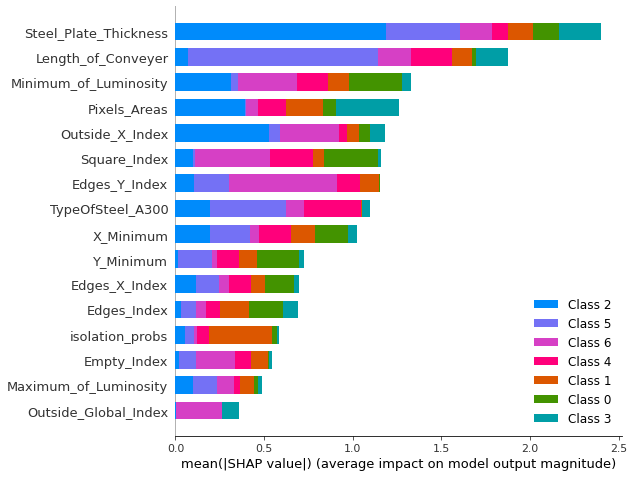

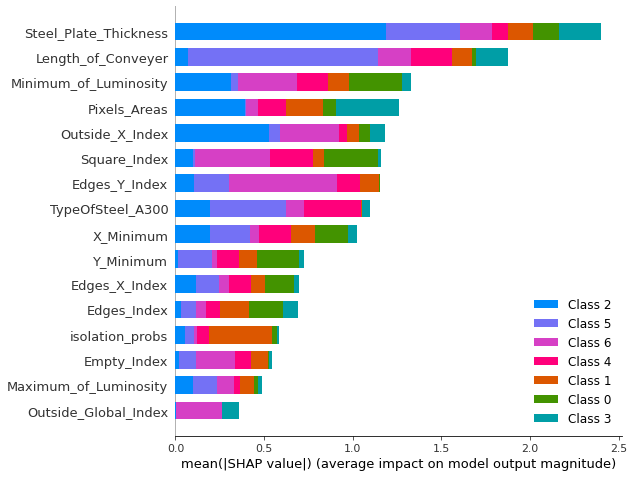

829     0.0
834     0.0
1302    1.0
1279    1.0
1342    1.0
       ... 
343     5.0
1499    1.0
1333    1.0
1042    4.0
1792    1.0
Name: target, Length: 1200, dtype: float64
166     5.0
369     2.0
705     2.0
296     5.0
704     2.0
       ... 
1747    1.0
1830    1.0
506     2.0
1498    1.0
1668    1.0
Name: target, Length: 300, dtype: float64
The Matthew correlation is 0.7349387978839235
The macro F1 score is 0.8027485905105306
The micro F1 score is 0.8000000000000002
The weighted F1 score is 0.800667007146903
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         8
         1.0       0.71      0.81      0.76       111
         2.0       0.96      0.92      0.94        60
         3.0       1.00      0.86      0.92         7
         4.0       0.74      0.70      0.72        61
         5.0       0.88      0.83      0.86        36
         6.0       0.80      0.71      0.75        17

    accuracy                           0.80   

In [5]:
# Run custom blueprint
custom_pipeline(None, steel_faults_ml)

In [6]:
# Save pipeline
try:
    save_to_production(steel_faults_ml, file_name='steel_faults_instance')
except AttributeError:
    print("""Unfortunately this does not work with version 0.9.4 when e2eml has to label encode the target labels automatically.
    For saving a pipeline please provide encoded target labels. This is solved for all other releases.""")

# Predict on new data
In the beginning we kept a holdout dataset. We use this to simulate prediction on completely new data.

In [7]:
# load stored pipeline...we skip this accordingly
steel_faults_ml_loaded = load_for_production(file_name='steel_faults_instance')

In [8]:
# label encode targets
val_df_target = steel_faults_ml_loaded.label_encoder_decoder(val_df_target, mode='transform')

# predict on new data
custom_pipeline(val_df, steel_faults_ml_loaded)

# access predicted labels
val_y_hat = steel_faults_ml_loaded.predicted_classes['lgbm']

Started Execute label encoding at 15:28:10.
Started Execute test train split at 15:28:10.
Started Apply datetime transformation at 15:28:10.
Started Start Spacy, POS tagging + PCA at 15:28:10.
Started Remove cardinality at 15:28:10.
Started Onehot + PCA categorical features at 15:28:10.
Started Execute categorical encoding at 15:28:10.
X_Minimum                0
X_Maximum                8
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    6
Edges_Index              0
Empty_Index              9
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_In

In [9]:
# Assess prediction quality on holdout data
print(classification_report(val_df_target, val_y_hat))
try:
    matthews = matthews_corrcoef(val_df_target, val_y_hat)
except Exception:
    print("Matthew failed.")
    matthews = 0
print(matthews)

              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        12
         1.0       0.66      0.81      0.72       140
         2.0       0.98      0.93      0.95        99
         3.0       0.93      0.93      0.93        15
         4.0       0.75      0.64      0.69        92
         5.0       0.93      0.95      0.94        39
         6.0       0.74      0.59      0.66        44

    accuracy                           0.79       441
   macro avg       0.85      0.76      0.79       441
weighted avg       0.80      0.79      0.79       441

0.7278100012190822
